# Convergent Cross Mapping / Sugihara Causality
<br>Prince Javier
<br>PhD in Data Science
<br>Asian Institute of Management

## References
**Main references**
* https://science.sciencemag.org/content/338/6106/496
* https://science.sciencemag.org/content/suppl/2012/09/19/science.1227079.DC1

**Supplementary materials**
* https://www.pnas.org/content/pnas/suppl/2016/10/26/1607747113.DCSupplemental/pnas.1607747113.sapp.pdf
* https://cran.microsoft.com/snapshot/2018-07-06/web/packages/rEDM/vignettes/rEDM-algorithms.pdf
* https://www.zora.uzh.ch/id/eprint/129395/1/Simplex_projection_walkthrough.pdf
* https://arxiv.org/pdf/1603.01155.pdf
* https://web.iitd.ac.in/~sumeet/Sahil_Parul_btp_thesis.pdf
* http://www.scholarpedia.org/article/Attractor_reconstruction

## Let's Play a Game
I'll show yoy charts of trajectories of two variables. Your goal is to guess if there's causation (one causes the other) between the variables.

In [1]:
!pip install jdc

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from scipy.interpolate import make_interp_spline
from tqdm import tqdm # for showing progress bar in for loops
import jdc # used fo defining functions for a class in separate cells

/Users/prince.javier/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def make_plots(df, dt_name, val1_name, val2_name):
    # smoothen
    date_smooth = np.linspace(df[dt_name].min(), df[dt_name].max(), 100) 
    spl = make_interp_spline(df[dt_name], df[val1_name], k=2)
    val1 = spl(date_smooth)
    spl = make_interp_spline(df[dt_name], df[val2_name], k=2)
    val2 = spl(date_smooth)    
    correl = np.round(np.corrcoef(df[val1_name], df[val2_name])[0][1], 2) # correlation coefficient
    
    # plot
    f, ax = plt.subplots(figsize=(12, 4))
    ax.plot(date_smooth, val1, )
    ax = df.plot(x=dt_name, y=val1_name, marker='o', c='b', linestyle='', legend=False, ax=ax)
    ax2 = ax.twinx()
    ax2.plot(date_smooth, val2, c='r')
    df.plot(x=dt_name, y=val2_name, marker='o', c='r', linestyle='', legend=False, ax=ax2)
    ax.figure.legend()        
    plt.title(f"{val1_name} and {val2_name}, correlation coefficient: {correl}", size=16)
    plt.tight_layout()
    plt.show()

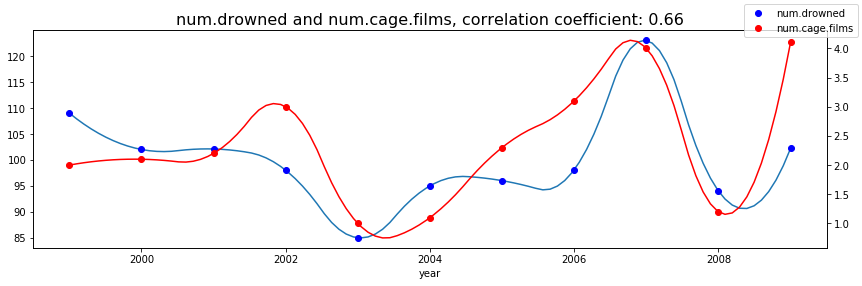

In [4]:
df = pd.read_csv('data/chart2.csv')
df['year'] = range(1999, 2010)
make_plots(df, 'year', 'num.drowned', 'num.cage.films')

## Background

### Why understand causation?

### Correlation is not causation

### Granger's Causality works for special cases

## CCM / Sugihara Causality

### Applicability

### How and why does it work?

<CONCEPTS, illustrations, related concepts, CHARTS here>

#### Takens' Embedding Theorem

### Assumptions and Limitations

## Sample System

We show here a sample nonlinear system. Here, we explicitly defined $X$ to be influenced by $Y$ and vice versa. The effect of $X$ on $Y$ is a factor of $\beta_{y,x}$ and the effect of $Y$ on $X$ is a factor of $\beta_{x,y}$. One way to read $\beta_{y,x}$: "the influence of $x$ on $y$". $r_x$ and $r_y$ are some constants that affect how chaotic the system is. As we increase $r$ say $r > 3.5$ we get more unpredictable ("chaotic") behavior.

$X(t+1)=X(t)[r_x-r_xX_t-\beta_{x,y}Y(t)]$
<br>$Y(t+1)=Y(t)[r_y-r_yY_t-\beta_{y,x}X(t)]$

Some of our questions:
* Can we detect the interaction between these two variables by looking at the correlation between them?
* Can we detect that X influences Y and vice versa via the Granger causality framework? (ADD GRANGER CAUSALITY DISCUSSION)
* Can convergent cross mapping help us find this out?

In [5]:
def func_1(A, B, r, beta):
    return A * (r - r * A - beta * B)

In [6]:
# params
r_x = 3.8
r_y = 3.5
B_xy = 0.02 # effect on x given y (effect of y on x)
B_yx = 0.1 # effect on y given x (effect of x on y)

X0 = 0.4 # initial val
Y0 = 0.2 # initial val
t = 5000 # time steps

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = func_1(X[-1], Y[-1], r_x, B_xy)
    Y_ = func_1(Y[-1], X[-1], r_y, B_yx)    
    X.append(X_)
    Y.append(Y_)        

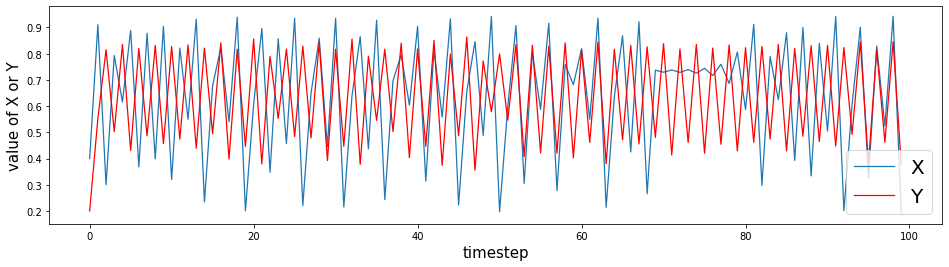

In [7]:
plt.figure(figsize=(16,4))
max_t = 100
plt.plot(X[:max_t], linewidth=1.25, label='X')
plt.plot(Y[:max_t], c='r', linewidth=1.25, label='Y')
plt.xlabel('timestep', size=15)
plt.ylabel('value of X or Y', size=15)
plt.legend(prop={'size': 20})

**Discussion**
1. Is the system chaotic or random? Say got these data the first time without knowing the equations, which tests can we apply to check if the system is chaotic or random?
* What conclusions about causality can we infer from this plot?

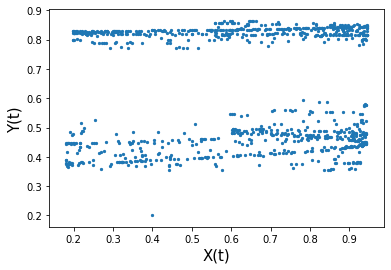

0.005395539983091764

In [8]:
# correlations in the first 1000 time steps
max_t = 1000
x, y = X[:max_t], Y[:max_t]
plt.scatter(x, y, s=5)
plt.xlabel('X(t)', size=15)
plt.ylabel('Y(t)', size=15)
plt.show()
np.corrcoef(x, y)[0][1]

**Discussion**

Though we explicitly defined Y to be a function of X (X influences Y), we find no correlation between them in the long term. 
<br>Based on this correlation value, what can we conclude about the relationship between X and Y (e.g. whether or not X influences Y or vice versa)?

## CCM Algorithm

1. Given two time series $X = \{X(1), X(2), ..., X(L)\}$ and $Y = \{Y(1), Y(2), ..., Y(L)\}$ where $L$ is time series length
* Compute lagged-coordinate vectors $\underline{x}(t) = <X(t), X(t-\tau), X(t-2\tau), ..., X(t-(E-1)\tau)>$ for $t \in [1+(E-1)\tau, L]$ where $E$ is an "embedding" dimension. Search algorithms e.g. grid search can be used to identify what the best $E$ value is. $\tau$ is the lag step.
* Define the "shadow (attractor) manifold" $M_x = \{\underline{x}(t) \text{ for each } t \in [1+(E-1)\tau, L]\}$
* At $t$, locate $\underline{x}(t)$ in $M_x$
* Find the $E+1$ nearest neighbor vectors from selected vector $\underline{x}(t)$. Sugihara, et al. noted that $E+1$ is the minimum number of points needed for an "embedding/simplex" with $E$ dimensions. Intuitively, if you have a 2D matrix, you need 3 points (2 + 1) to "triangulate" a point
* Denote the time indices of the $E+1$ nearest neighbors of $\underline{x}(t)$ by $t_1, ..., t_{E+1}$. These indices will be used to identify the corresponding points in $Y$.
* Define the model that predicts $Y$ given $M_x$ as $\hat{Y} | M_x = \Sigma{w_iY(t_i)}$ where $i = 1 ... E+1$ where $w_i$ is the weight multiplied by the corresponding $Y(t_i)$
    1. $w_i = u_i / \Sigma{u_j}$ where $j = 1...E+1$
    * $u_i = exp[-d(\underline{x}(t), \underline{x}(t_i))/d(\underline{x}(t), \underline{x}(t_1))]$ where $d(\underline{x}(s), \underline{x}(t))$ is a Euclidean distance. Note that we divide by $d(x(t), x(t_1))$ to "scale" the distances as a multiples of the distance to the closest point. Though not sure why this is necessary.
* If $X$ and $Y$ are dynamically "coupled" i.e. one influences the other, a clump of points in $M_x$ should correspond to a clump of points in $M_y$. And as $L$ increases, we get a denser cluster of $E+1$ points from $M_x$ that correspond to a denser cluster of points in $M_y$. Given this, $\hat{Y} | M_x$ intuitively should converge to $Y$ as $L$ increases, e.g. we get more data/samples. Hence, we can test for convergence of the nearest neighbors to test for correspondence between states on $M_x$ and $M_y$.
* We then plot the correlation coefficients between $Y$ and $\hat{Y} | M_x$. If there is significant correlation, this means we have enough information from $Y$ that is stored in $X$. We say that $Y$ influences $X$. It sounds counter intuitive but another way to think about it is: if $Y$ influences $X$ then information from $Y$ gets stored in $X$. We can thus use $X$ to predict $Y$. Same goes for $X$ influencing $Y$.

### CCM Functions

In [10]:
def shadow_manifold(X, tau, E, L):
    """
    Args
        X: some time series vector
        tau: lag step
        E: shadow manifold embedding dimension
        L: max time step to consider - 1 (starts from 0)
    Returns
        {t:[t, t-tau, t-2*tau ... t-(E-1)*tau]} = Shadow attractor manifold, dictionary of vectors
    """
    X = X[:L] # make sure we cut at L
    M = {t:[] for t in range((E-1) * tau, L)} # shadow manifold
    for t in range((E-1) * tau, L):
        x_lag = [] # lagged values
        for t2 in range(0, E-1 + 1): # get lags, we add 1 to E-1 because we want to include E
            x_lag.append(X[t-t2*tau])            
        M[t] = x_lag
    return M

In [11]:
# get pairwise distances between vectors in X
def get_distances(Mx):
    """
    Args
        Mx: The shadow manifold from X
    Returns
        t_steps: timesteps
        dists: n x n matrix showing distances of each vector at t_step (rows) from other vectors (columns)
    """

    # we extract the time indices and vectors from the manifold Mx
    # we just want to be safe and convert the dictionary to a tuple (time, vector)
    # to preserve the time inds when we separate them
    t_vec = [(k, v) for k,v in Mx.items()]
    t_steps = np.array([i[0] for i in t_vec])
    vecs = np.array([i[1] for i in t_vec])
    dists = distance.cdist(vecs, vecs)    
    return t_steps, dists

In [12]:
def get_nearest_distances(t, t_steps, dists, E):
    """
    Args:
        t: timestep of vector whose nearest neighbors we want to compute
        t_teps: time steps of all vectors in Mx, output of get_distances()
        dists: distance matrix showing distance of each vector (row) from other vectors (columns). output of get_distances()
        E: embedding dimension of shadow manifold Mx 
    Returns:
        nearest_timesteps: array of timesteps of E+1 vectors that are nearest to vector at time t
        nearest_distances: array of distances corresponding to vectors closest to vector at time t
    """
    t_ind = np.where(t_steps == t) # get the index of time t
    dist_t = dists[t_ind].squeeze() # distances from vector at time t (this is one row)
    
    # get top closest vectors
    nearest_inds = np.argsort(dist_t)[1:E+1 + 1] # get indices sorted, we exclude 0 which is distance from itself
    nearest_timesteps = t_steps[nearest_inds] # index column-wise, t_steps are same column and row-wise 
    nearest_distances = dist_t[nearest_inds]  
    
    return nearest_timesteps, nearest_distances


In [55]:
# Computing "Causality" (Correlation between True and Predictions)

class ccm:
    def __init__(self, X, Y, tau=1, E=2, L=500):
        '''
        X: timeseries for variable X that could cause Y
        Y: timeseries for variable Y that could be caused by X
        tau: time lag
        E: shadow manifold embedding dimension
        L: time period/duration to consider (longer = more data)
        We're checking for X -> Y
        '''
        self.X = X
        self.Y = Y
        self.tau = tau
        self.E = E
        self.L = L        
        self.My = shadow_manifold(self.Y, self.tau, self.E, self.L) # shadow manifold for Y (we want to know if info from X is in Y)
        self.t_steps, self.dists = get_distances(self.My) # for distances between points in manifold    
        
    def causality(self):
        '''
        Args:
            None
        Returns:
            correl: how much self.X causes self.Y. correlation between predicted Y and true Y
        '''
        
        # run over all timesteps in M
        # X causes Y, we can predict X using My
        # X puts some info into Y that we can use to reverse engineer X from Y        
        X_true_list = []
        X_hat_list = []

        for t in list(self.My.keys()): # for each time step in My
            X_true, X_hat = self.predict(t) # predict X from My
            X_true_list.append(X_true)
            X_hat_list.append(X_hat)    

        x, y = X_true_list, X_hat_list
        correl = np.corrcoef(x, y)[0][1]
        return correl    

In [58]:
%%add_to ccm
def predict(self, t):
    """
    Args
        t: timestep at Mx to predict Y at same time step
    Returns
        Y_true: the true value of Y at time t
        Y_hat: the predicted value of Y at time t using Mx
    """
    
    t_ind = np.where(self.t_steps == t) # get the index of time t
    dist_t = self.dists[t_ind].squeeze() # distances from vector at time t (this is one row)    
    nearest_timesteps, nearest_distances = get_nearest_distances(t, self.t_steps, self.dists, E)    
    
    # get weights
    u = np.exp(-nearest_distances/nearest_distances[0]) # we divide by the closest distance to scale
    w = u / np.sum(u)
    
    # get prediction of X
    X_true = self.X[t] # get corresponding true X
    X_cor = np.array(self.X)[nearest_timesteps] # get corresponding Y to cluster in Mx
    X_hat = (w * X_cor).sum() # get Y_hat
    
    return X_true, X_hat
    
    

### Other Functions

In [72]:
def plot_ccm_correls(X, Y, tau, E, L):
    """
    Args
        X: X time series
        Y: Y time series
        tau: time lag
        E: shadow manifold embedding dimension
        L: time duration
    Returns
        None. Just correlation plots
    """
    M = shadow_manifold(Y, tau, E, L) # shadow manifold
    t_steps, dists = get_distances(M) # for distances

    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X

    X_My_true, X_My_pred = [], [] # note pred X | My is equivalent to figuring out if X -> Y
    Y_Mx_true, Y_Mx_pred = [], [] # note pred Y | Mx is equivalent to figuring out if Y -> X

    for t in range(tau, L):
        true, pred = ccm_XY.predict(t)
        X_My_true.append(true)
        X_My_pred.append(pred)    

        true, pred = ccm_YX.predict(t)
        Y_Mx_true.append(true)
        Y_Mx_pred.append(pred)        

    # # plot
    coeff = np.round(np.corrcoef(X_My_true, X_My_pred)[0][1], 2)
    plt.scatter(X_My_true, X_My_pred, s=10)
    plt.xlabel('$X(t)$ (observed)', size=15)
    plt.ylabel('$\hat{X}(t)|M_y$ (estimated)', size=15)
    plt.title(f'tau={tau}, E={E}, L={L}, Correlation coeff = {coeff}')
    plt.show()
    coeff = np.round(np.corrcoef(Y_Mx_true, Y_Mx_pred)[0][1])
    plt.scatter(Y_Mx_true, Y_Mx_pred, s=10)
    plt.xlabel('$Y(t)$ (observed)', size=15)
    plt.ylabel('$\hat{Y}(t)|M_x$ (estimated)', size=15)
    plt.title(f'tau={tau}, E={E}, L={L}, Correlation coeff = {coeff}')
    plt.show()


## CCM In Action

### Can CCM predict causality in our test system?
Remember our test system is:

$X(t+1)=X(t)[r_x-r_xX_t-\beta_{x,y}Y(t)]$
<br>$Y(t+1)=Y(t)[r_y-r_yY_t-\beta_{y,x}X(t)]$

In [67]:
# Initialize test dataset
# params
r_x = 3.8
r_y = 3.5
B_xy = 0.02 # effect on x given y (effect of y on x)
B_yx = 0.1 # effect on y given x (effect of x on y)

X0 = 0.4 # initial val
Y0 = 0.2 # initial val
t = 5000 # time steps

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = func_1(X[-1], Y[-1], r_x, B_xy)
    Y_ = func_1(Y[-1], X[-1], r_y, B_yx)    
    X.append(X_)
    Y.append(Y_)        

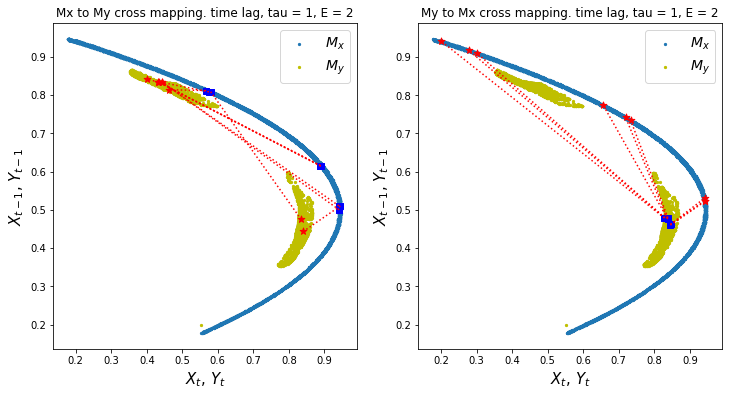

In [24]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(0) # we fix the seed when randomly choosing cross mapping points
f, axs = plt.subplots(1, 2, figsize=(12, 6))
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = 500

# we want to check cross mapping from Mx to My and My to Mx
for i, ax in zip((0, 1), axs): # i will be used in switching Mx and My in Cross Mapping visualization
    #===============================================
    # Shadow Manifolds Visualization

    X_lag, Y_lag = [], []
    for t in range(1, len(X)):
        X_lag.append(X[t-tau])
        Y_lag.append(Y[t-tau])    
    X_t, Y_t = X[1:], Y[1:] # remove first value

    ax.scatter(X_t, X_lag, s=5, label='$M_x$')
    ax.scatter(Y_t, Y_lag, s=5, label='$M_y$', c='y')

    #===============================================
    # Cross Mapping Visualization
    
    A, B = [(X, Y), (Y, X)][i]
    cm_direction = ['Mx to My', 'My to Mx'][i]

    Ma = shadow_manifold(A, tau, E, L)
    Mb = shadow_manifold(B, tau, E, L)

    t_steps_A, dists_A = get_distances(Ma) # for distances between points in manifold
    t_steps_B, dists_B = get_distances(Mb) # for distances between points in manifold

    # Plot cross mapping for different time steps
    timesteps = list(Ma.keys())
    for t in np.random.choice(timesteps, size=3, replace=False):
        Ma_t = Ma[t]
        near_t_A, near_d_A = get_nearest_distances(t, t_steps_A, dists_A, E)

        for i in range(E+1):
            # points on Ma
            A_t = Ma[near_t_A[i]][0]
            A_lag = Ma[near_t_A[i]][1]
            ax.scatter(A_t, A_lag, c='b', marker='s')

            # corresponding points on Mb
            B_t = Mb[near_t_A[i]][0]
            B_lag = Mb[near_t_A[i]][1]
            ax.scatter(B_t, B_lag, c='r', marker='*', s=50)  

            # connections
            ax.plot([A_t, B_t], [A_lag, B_lag], c='r', linestyle=':') 

    ax.set_title(f'{cm_direction} cross mapping. time lag, tau = {tau}, E = 2')
    ax.legend(prop={'size': 14})

    ax.set_xlabel('$X_t$, $Y_t$', size=15)
    ax.set_ylabel('$X_{t-1}$, $Y_{t-1}$', size=15)               
plt.show()       

**Discussion**

In the shadow manifolds above, we show the cross mapping of points from one manifold (blue box) to the corresponding points on the other manifold (red star)

1. What is the implication on causality when values from one manifold make a spread out cross mapping to values on another manifold?
* What is the implication on causality if the cross mapping is more narrow?

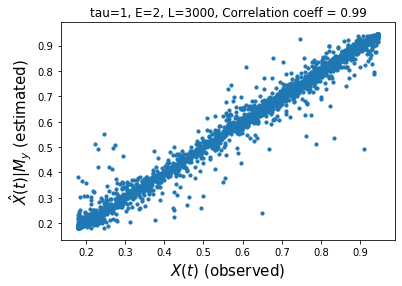

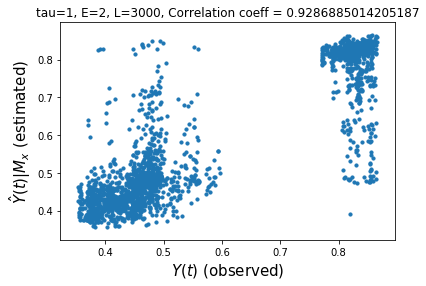

In [68]:
# let us plot the performance of the cross mapping predictions using correlation
L = 3000
tau = 1
E = 2
plot_ccm_correls(X, Y, tau, E, L)

**Discussion**
1. Based on these plots which variable has more influence over the other i.e. causes the other more?
* We have shown cross-mapping in both directions though one direction is stronger. In the CCM framework, is the existence of cross-mapping from say X to Y or Y to X sufficient to conclude causality?

In [39]:
# Looking at "convergence"
L_range = range(20, 3100, 100) # L values to test
tau = 1
E = 2

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()) 
    Yhat_Mx.append(ccm_YX.causality())    

100%|██████████| 31/31 [00:30<00:00,  1.03it/s]


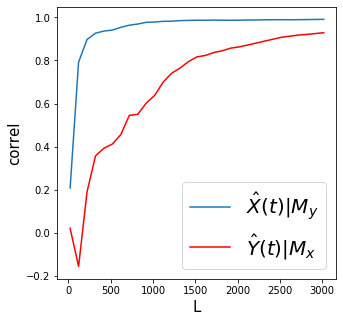

In [40]:
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, c='r', label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=15)
plt.ylabel('correl', size=15)
plt.legend(prop={'size': 20})

**Discussion**
1. Assuming the CCM methodology is correct, what can we conclude from this plot about the interactions between $X$ and $Y$?
* How do we interpret this in the context of "convergence" in the CCM method?
* What do the trends approach as we look at longer time periods $L$?
* Do we have enough evidence based on the CCM framework to conclude causality?
* Which variable has more influence on the other?

### How Betas Affect Causality As Indicated By Convergence

In [43]:
# Checking convergence for various betas
# params
X0 = 0.4 # initial val
Y0 = 0.4 # initial val
t = 400 # time steps for the dataset
L = 400 # time steps for computing CCM
E = 2 # embedding dimensions

range_ = list(np.arange(0, 0.41, 0.01)) # B ranges
correl_diffs = np.zeros(shape=(len(range_), len(range_))) # correlation list
np.random.seed(42)

for ind_B_xy in tqdm(range(len(range_))): # effect on x given y (effect of y on x)
    for ind_B_yx in range(len(range_)): # effect on y given x (effect of x on y)
        
        r_x = np.random.choice(np.arange(3.6, 4.1, 0.01)) # paper implies random sampling
        r_y = np.random.choice(np.arange(3.6, 4.1, 0.01)) # paper implies random sampling

        B_xy = range_[ind_B_xy]
        B_yx = range_[ind_B_yx]
        
        # initialize dataset
        X, Y = [X0], [Y0]
        for i in range(t):
            X_ = func_1(X[-1], Y[-1], r_x, B_xy)
            Y_ = func_1(Y[-1], X[-1], r_y, B_yx)    
            X.append(X_)
            Y.append(Y_)
            
        # Testing for X -> Y
        ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object
        correl_xy = ccm_XY.causality()            

        # Testing for Y -> X
        ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object
        correl_yx = ccm_YX.causality()
        
        # get diffs 
        correl_diffs[ind_B_yx][ind_B_xy] = correl_yx - correl_xy # (y -> x) - (x-> y)

  0%|          | 0/41 [00:00<?, ?it/s]/Users/prince.javier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/Users/prince.javier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/Users/prince.javier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
 22%|██▏       | 9/41 [00:21<01:15,  2.35s/it]/Users/prince.javier/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2449: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
 29%|██▉       | 12/41 [00:28<01:07,  2.33s/it]/Users/prince.javier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_d

/Users/prince.javier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':


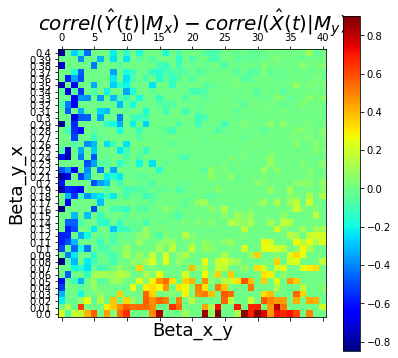

In [44]:
plt.figure(figsize=(6, 6))
plt.matshow(np.nan_to_num(correl_diffs), origin='lower', cmap='jet', fignum=1)
plt.xlabel('Beta_x_y', size=18)
plt.ylabel('Beta_y_x', size=18)
plt.title('$correl(\hat{Y}(t)|M_x) - correl(\hat{X}(t)|M_y$)', size=20)
# plt.xticks(range(len(range_)), np.round(range_, 2), rotation=90)
plt.yticks(range(len(range_)), np.round(range_, 2))
plt.colorbar()
plt.tight_layout()
plt.show()

**Discussion**

The chart above shows the difference in predictive performance $\rho(\hat{Y}|M_x) - \rho(\hat{X}|M_y)$ for different $\beta_{y,x}$ and $\beta_{x,y}$. Remember that $\beta_{y,x}$ is how much $X$ influences $Y$ and that a higher score $\rho(\hat{X}|M_y)$ means we are able to predict $X$ better from $Y$ indicating that much of information from $X$ gets stored in $Y$ or in other words, $X$ causes $Y$. Note that the "spots" in the chart can be due to our randomization of the value of $r_x$ and $r_y$ in each iteration. (We followed the method of randomizing $r$ as implied in the supplemental materials in Sugihara et al's paper. Their chart also has spots.)

1. Based on the plot, as $\beta_{y,x}$ increases, what happens to our predicted $\hat{Y}|M_x$ and $\hat{X}|M_y$?
* Do the results align with our intuition that higher $\beta_{y,x}$ means higher effect of $X$ on $Y$?

### What if asymmetrically coupled (the effect is only in one direction)?

Let us define our system as

$X(t+1)=X(t)[3.7-3.7X_t-0Y(t)]$
<br>$Y(t+1)=Y(t)[3.7-3.7Y_t-0.32X(t)]$

Are we convinced that this system has causality in one direction only?

In [70]:
# Initialize test dataset
# params
r_x = 3.7
r_y = 3.7
B_xy = 0 # effect on x given y (effect of y on x)
B_yx = 0.32 # effect on y given x (effect of x on y)

X0 = 0.2 # initial val following Sugihara et al
Y0 = 0.4 # initial val following Sugihara et al
t = 5000 # time steps

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = func_1(X[-1], Y[-1], r_x, B_xy)
    Y_ = func_1(Y[-1], X[-1], r_y, B_yx)    
    X.append(X_)
    Y.append(Y_)        

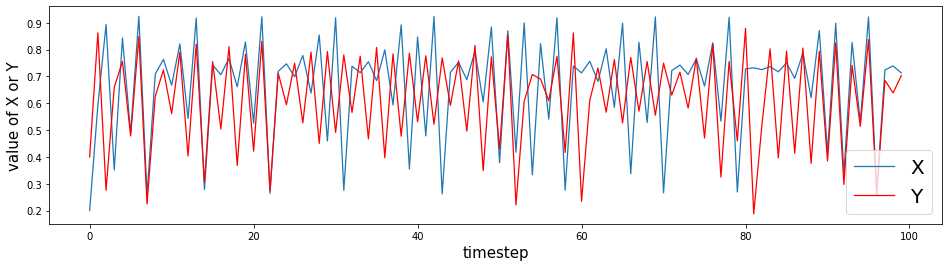

In [48]:
plt.figure(figsize=(16,4))
max_t = 100
plt.plot(X[:max_t], linewidth=1.25, label='X')
plt.plot(Y[:max_t], c='r', linewidth=1.25, label='Y')
plt.xlabel('timestep', size=15)
plt.ylabel('value of X or Y', size=15)
plt.legend(prop={'size': 20})

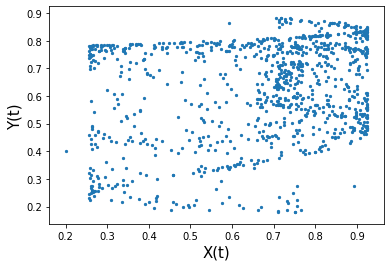

0.248134841319132

In [49]:
# correlations in the first 1000 time steps
max_t = 1000
x, y = X[:max_t], Y[:max_t]
plt.scatter(x, y, s=5)
plt.xlabel('X(t)', size=15)
plt.ylabel('Y(t)', size=15)
plt.show()
np.corrcoef(x, y)[0][1]

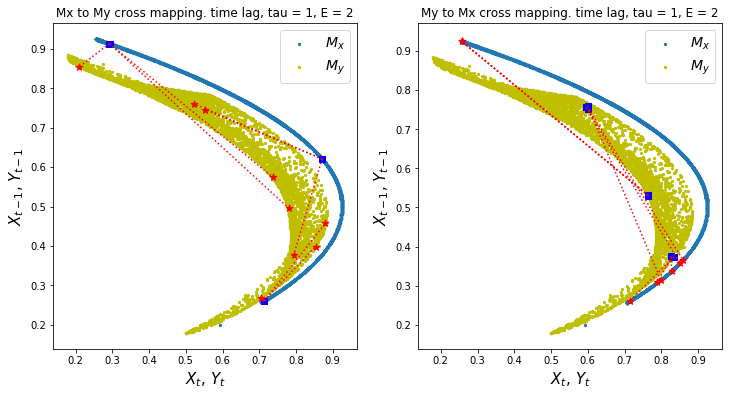

In [47]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
f, axs = plt.subplots(1, 2, figsize=(12, 6))
tau = 1 # time lag

# we want to check cross mapping from Mx to My and My to Mx
for i, ax in zip((0, 1), axs): # i will be used in switching Mx and My in Cross Mapping visualization
    #===============================================
    # Shadow Manifolds Visualization

    X_lag, Y_lag = [], []
    for t in range(1, len(X)):
        X_lag.append(X[t-tau])
        Y_lag.append(Y[t-tau])    
    X_t, Y_t = X[1:], Y[1:] # remove first value

    ax.scatter(X_t, X_lag, s=5, label='$M_x$')
    ax.scatter(Y_t, Y_lag, s=5, label='$M_y$', c='y')

    #===============================================
    # Cross Mapping Visualization
    
    A, B = [(X, Y), (Y, X)][i]
    cm_direction = ['Mx to My', 'My to Mx'][i]

    Ma = shadow_manifold(A, tau, E, L)
    Mb = shadow_manifold(B, tau, E, L)

    t_steps_A, dists_A = get_distances(Ma) # for distances between points in manifold
    t_steps_B, dists_B = get_distances(Mb) # for distances between points in manifold

    # Plot cross mapping for different time steps
    timesteps = list(Ma.keys())
    for t in np.random.choice(timesteps, size=3, replace=False):
        Ma_t = Ma[t]
        near_t_A, near_d_A = get_nearest_distances(t, t_steps_A, dists_A, E)

        for i in range(E+1):
            # points on Ma
            A_t = Ma[near_t_A[i]][0]
            A_lag = Ma[near_t_A[i]][1]
            ax.scatter(A_t, A_lag, c='b', marker='s')

            # corresponding points on Mb
            B_t = Mb[near_t_A[i]][0]
            B_lag = Mb[near_t_A[i]][1]
            ax.scatter(B_t, B_lag, c='r', marker='*', s=50)  

            # connections
            ax.plot([A_t, B_t], [A_lag, B_lag], c='r', linestyle=':') 

    ax.set_title(f'{cm_direction} cross mapping. time lag, tau = {tau}, E = 2')
    ax.legend(prop={'size': 14})

    ax.set_xlabel('$X_t$, $Y_t$', size=15)
    ax.set_ylabel('$X_{t-1}$, $Y_{t-1}$', size=15)               
plt.show()       

**Discussion**
1. What can you observe about the cross mappings between the two manifolds in this system? Remember that the direction of cross mapping is from the blue squares to the red stars
* Is this something that we expected?

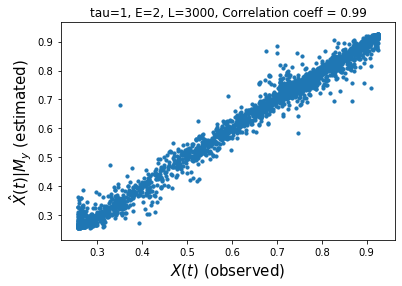

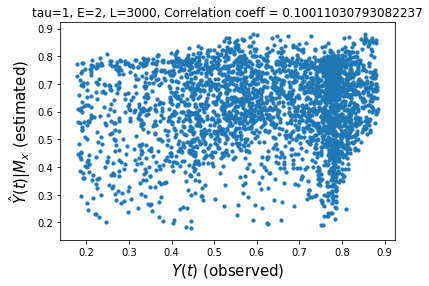

In [71]:
# let us plot the performance of the cross mapping predictions using correlation
L = 3000
tau = 1
E = 2
plot_ccm_correls(X, Y, tau, E, L)

**Discussion**
1. Are the results here expected? 
* How do we interpret these charts in the context of determining causality using the CCM framework?

## Application in Real World Systems

### Nicolas Cage Films and Number of Drowned Victims in the US

In [51]:
df = pd.read_csv('data/chart2.csv')
df.head()

,num.cage.films,num.drowned
0,2.0,109.0
1,2.1,102.0
2,2.2,102.1
3,3.0,98.0
4,1.0,85.0


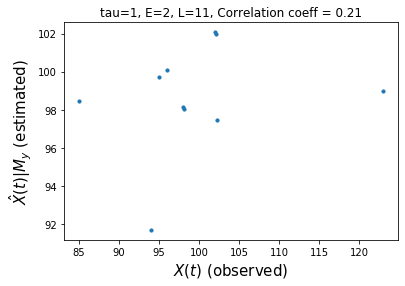

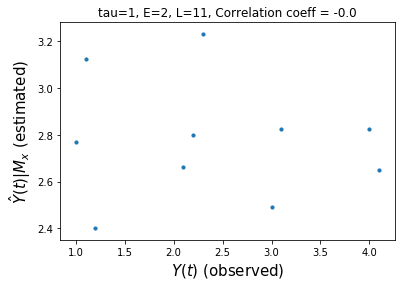

In [73]:
Y = df['num.cage.films'].values
X = df['num.drowned'].values

tau = 1
E = 2
L = len(X)
plot_ccm_correls(X, Y, tau, E, L)

### Paramecium and Didinium Interactions

### Sardine-Anchovy Interactions

### CO2 emissions and global temperature (Non-ecological)

## Appendix

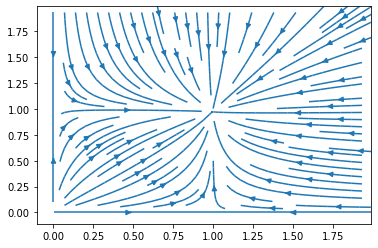

In [60]:
# I don't know why the phase space goes to (1, 1) in our system of equations
from pylab import *

r_x = 3.8
r_y = 3.5
B_xy = 0.02 # effect on x given y (effect of y on x)
B_yx = 0.1 # effect on y given x (effect of x on y)

xvals, yvals = meshgrid(np.arange(0., 2, 0.01), np.arange(0, 2, 0.01))
Xs = func_1(xvals, yvals, r_x, B_xy)
Ys = func_1(yvals, xvals, r_y, B_yx)

streamplot(xvals, yvals, Xs, Ys)